In [1]:
!pip3 install pandas


In [207]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt




## Reading the collections of database

In [3]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]

def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    #if no_id:
    #    del df['_id']

    return df


## Lendo recommendation tracks

In [4]:
recommendation_tracks = read_mongo(db="social_tracks_api", collection="recommendationtracks")
recommendation_tracks = recommendation_tracks.rename(columns = {"id" : "spotify_track_id", "_id" : "recommendation_tracks_ids" })
recommendation_tracks.drop(["__v","external_urls","album", "artists","created_at","explicit","updated_at","uri", "preview_url"],axis=1, inplace=True)

recommendation_tracks.head()

,recommendation_tracks_ids,spotify_track_id,name,prediction
0,5e38a40320eff00bbfe6eb56,5MxNLUsfh7uzROypsoO5qe,Dream On,1.192416
1,5e38a40320eff00bbfe6eb57,31AOj9sFz2gM0O3hMARRBx,Losing My Religion,1.187708
2,5e38a40420eff00bbfe6eb59,37ZJ0p5Jm13JPevGcx4SkF,Livin' On A Prayer,1.167886
3,5e38a40420eff00bbfe6eb5a,5sICkBXVmaCQk5aISGR3x1,Enter Sandman,1.140450
4,5e38a40420eff00bbfe6eb5b,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,0.972769


## Lendo Ratings

In [78]:
ratings = read_mongo(db="social_tracks_api", collection="ratings")
ratings.drop(['__v', 'created_at', 'updated_at', "_id"], axis=1, inplace=True)
ratings =  ratings.rename(columns = {"user" : "coldstart_id"})
ratings['coldstart_id'] = ratings['coldstart_id'].astype('|S')
ratings


,coldstart_id,value,spotify_track_id
0,b'5e3c828776310e1fde421f2c',5,1KGBjK7e8yq2kGiATF6RxC
1,b'5e3c828776310e1fde421f2c',5,2nLtzopw4rPReszdYBJU6h
2,b'5e39ede810214506a1c42a62',4,75JFxkI2RXiU7L9VXzMkle
3,b'5e39ede810214506a1c42a62',4,5qqabIl2vWzo9ApSC317sa
4,b'5e39ede810214506a1c42a62',4,5VGlqQANWDKJFl0MBG3sg2
...,...,...,...
300,b'5e3c74b676310e1fde421f2b',3,5MxNLUsfh7uzROypsoO5qe
301,b'5e3c74b676310e1fde421f2b',5,1AdYZ6X00nXmO613Y7GJOl
302,b'5e3c74b676310e1fde421f2b',1,5sICkBXVmaCQk5aISGR3x1
303,b'5e3c74b676310e1fde421f2b',5,2DlHlPMa4M17kufBvI2lEN


## Lendo as recommendations

In [79]:
recommendations = read_mongo(db="social_tracks_api", collection="recommendations")
recommendations.drop(["__v", 'generating_recommendation', 'created_at','updated_at'], axis=1, inplace=True)
recommendations =  recommendations.rename(columns={'coldstart_user':'coldstart_id'})
recommendations['coldstart_id'] =  recommendations['coldstart_id'].astype('|S')
recommendations.head()

,_id,recommendation_tracks,recommendations_without_influence_tracks,coldstart_id,influence_factors
0,5e4ee62b5ca8220c4dc01354,"[5e4ee9475ca8220c4dc01355, 5e4ee9475ca8220c4dc...","[5e4ee9485ca8220c4dc0135f, 5e4ee9485ca8220c4dc...",b'5e3b33d7ed270009cf00da85',{'final': {'5e3b33d7ed270009cf00da85': 1.09042...
1,5e4eedb35ca8220c4dc01369,"[5e4ef0465ca8220c4dc0136a, 5e4ef0465ca8220c4dc...","[5e4ef0475ca8220c4dc01374, 5e4ef0485ca8220c4dc...",b'5e3c828776310e1fde421f2c',{'final': {'5e39d31110214506a1c42a5f': 1.22941...
2,5e4eda635ca8220c4dc0133f,"[5e4edd995ca8220c4dc01340, 5e4edd995ca8220c4dc...","[5e4edd9a5ca8220c4dc0134a, 5e4edd9a5ca8220c4dc...",b'5e3726ba1fbed90c602336a4',{'final': {'5e3726ba1fbed90c602336a4': 1.18666...
3,5e4ef2325ca8220c4dc0137e,"[5e4ef4c75ca8220c4dc01383, 5e4ef4c75ca8220c4dc...","[5e4ef4c85ca8220c4dc0138d, 5e4ef4c85ca8220c4dc...",b'5e39ede810214506a1c42a62',{'final': {'5e3b33d7ed270009cf00da85': 1.08978...
4,5e4ef7ca5ca8220c4dc013a0,"[5e4efaa65ca8220c4dc013a5, 5e4efaa65ca8220c4dc...","[5e4efaa75ca8220c4dc013af, 5e4efaa75ca8220c4dc...",b'5e3888bf76eb8c0a84f6030c',{'final': {'5e3b33d7ed270009cf00da85': 1.15278...



## extraindo os fatores de influencia



In [80]:
influence_factors_results =  recommendations.copy()
influence_factors_results.drop(['_id', 'recommendation_tracks','recommendations_without_influence_tracks' ], axis=1, inplace=True)
influence_factors_results.head()


,coldstart_id,influence_factors
0,b'5e3b33d7ed270009cf00da85',{'final': {'5e3b33d7ed270009cf00da85': 1.09042...
1,b'5e3c828776310e1fde421f2c',{'final': {'5e39d31110214506a1c42a5f': 1.22941...
2,b'5e3726ba1fbed90c602336a4',{'final': {'5e3726ba1fbed90c602336a4': 1.18666...
3,b'5e39ede810214506a1c42a62',{'final': {'5e3b33d7ed270009cf00da85': 1.08978...
4,b'5e3888bf76eb8c0a84f6030c',{'final': {'5e3b33d7ed270009cf00da85': 1.15278...


In [81]:
influence_factors_results.style

,coldstart_id,influence_factors
0,b'5e3b33d7ed270009cf00da85',"{'final': {'5e3b33d7ed270009cf00da85': 1.0904294456186723, '5e3726ba1fbed90c602336a4': 1.1845473337307584, '5e37790d1fbed90c602336ac': 1.1816925402147118, '5e3888bf76eb8c0a84f6030c': 1.3081248278071014, '5e4ea09d53da9b09dcfa3e40': 1.230618998029443, '5e39e05f10214506a1c42a61': 1.3101725714476933}, 'leadership': {'5e3b33d7ed270009cf00da85': 0.2923658768132452, '5e3726ba1fbed90c602336a4': 0.18795675345675347, '5e37790d1fbed90c602336ac': 0.3027080884762044, '5e3888bf76eb8c0a84f6030c': 0.43558725836784473, '5e4ea09d53da9b09dcfa3e40': 0.3713895590565429, '5e39e05f10214506a1c42a61': 0.4099924638294091}, 'similarities': {'5e3b33d7ed270009cf00da85': 0.08048031780426146, '5e3726ba1fbed90c602336a4': 0.09047619047619046, '5e37790d1fbed90c602336ac': 0.10100250626566414, '5e3888bf76eb8c0a84f6030c': 0.159496336996337, '5e4ea09d53da9b09dcfa3e40': 0.17118544600938965, '5e39e05f10214506a1c42a61': 0.1386581839213418}, 'expert': {'5e3b33d7ed270009cf00da85': 0, '5e3726ba1fbed90c602336a4': 0.5214805448713519, '5e37790d1fbed90c602336ac': 0.2864283239657016, '5e3888bf76eb8c0a84f6030c': 0.5214024642758981, '5e4ea09d53da9b09dcfa3e40': 0.37138523797649947, '5e39e05f10214506a1c42a61': 0.799303428910549}, 'friendly': {'5e3b33d7ed270009cf00da85': 0.07220700595700595, '5e3726ba1fbed90c602336a4': 0.07124943039416723, '5e37790d1fbed90c602336ac': 0.163667979194295, '5e3888bf76eb8c0a84f6030c': 0.3073781213912793, '5e4ea09d53da9b09dcfa3e40': 0.14380936558568136, '5e39e05f10214506a1c42a61': 0.15068606344922136}}"
1,b'5e3c828776310e1fde421f2c',"{'final': {'5e39d31110214506a1c42a5f': 1.2294159990258986, '5e3726ba1fbed90c602336a4': 1.3578134265140234, '5e37790d1fbed90c602336ac': 1.267802263903532, '5e3c828776310e1fde421f2c': 1.0843428998984554}, 'leadership': {'5e39d31110214506a1c42a5f': 0.44733175439697187, '5e3726ba1fbed90c602336a4': 0.3649801620816114, '5e37790d1fbed90c602336ac': 0.2841286799620133, '5e3c828776310e1fde421f2c': 0.2368927368927369}, 'similarities': {'5e39d31110214506a1c42a5f': 0.10702614379084967, '5e3726ba1fbed90c602336a4': 0.19763460939931524, '5e37790d1fbed90c602336ac': 0.248015873015873, '5e3c828776310e1fde421f2c': 0.12037037037037036}, 'expert': {'5e39d31110214506a1c42a5f': 0.2526048918592778, '5e3726ba1fbed90c602336a4': 0.7528587580980319, '5e37790d1fbed90c602336ac': 0.49453635004269003, '5e3c828776310e1fde421f2c': 0}, 'friendly': {'5e39d31110214506a1c42a5f': 0.28665123456790126, '5e3726ba1fbed90c602336a4': 0.2982142857142857, '5e37790d1fbed90c602336ac': 0.11926807760141094, '5e3c828776310e1fde421f2c': 0.01728395061728395}}"
2,b'5e3726ba1fbed90c602336a4',"{'final': {'5e3726ba1fbed90c602336a4': 1.1866641608210236, '5e39cb7410214506a1c42a5e': 1.1025954117313899, '5e37790d1fbed90c602336ac': 1.2672251094528324, '5e3aef57b3895f08cb77ad4a': 1.2137871680890875, '5e3c74b676310e1fde421f2b': 1.04725868120071, '5e39d31110214506a1c42a5f': 1.2238264160422958}, 'leadership': {'5e3726ba1fbed90c602336a4': 0.47497150997151005, '5e39cb7410214506a1c42a5e': 0.26237281237281235, '5e37790d1fbed90c602336ac': 0.377993302993303, '5e3aef57b3895f08cb77ad4a': 0.3096743996743997, '5e3c74b676310e1fde421f2b': 0.08055555555555556, '5e39d31110214506a1c42a5f': 0.4944324194324194}, 'similarities': {'5e3726ba1fbed90c602336a4': 0.12746965452847805, '5e39cb7410214506a1c42a5e': 0.05, '5e37790d1fbed90c602336ac': 0.1300595238095238, '5e3aef57b3895f08cb77ad4a': 0.06736111111111112, '5e3c74b676310e1fde421f2b': 0.02, '5e39d31110214506a1c42a5f': 0.0392156862745098}, 'expert': {'5e3726ba1fbed90c602336a4': 0, '5e39cb7410214506a1c42a5e': 0.21929641830964242, '5e37790d1fbed90c602336ac': 0.7530409466795621, '5e3aef57b3895f08cb77ad4a': 0.7004753194849164, '5e3c74b676310e1fde421f2b': 0.12876254180602006, '5e39d31110214506a1c42a5f': 0.6150914403865255}, 'friendly': {'5e3726ba1fbed90c602336a4': 0.27130036630036625, '5e39cb7410214506a1c42a5e': 0.014074074074074072, '5e37790d1fbed90c602336ac': 0.05322751322751322, '5e3aef57b3895f08cb7

In [27]:
#### Função de extração dos fatores de influencia

In [28]:
def influence_factors_dataframe(dict1):
    rows = []
    for factor, user_obj in dict1.items():
        for user_id, value in user_obj.items():
            #toma os valores que pertence a cada factor
            data_row =  { 'factor': factor, 'user_id': user_id, 'value': value }
            rows.append(data_row)
    return rows

In [29]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [82]:
list_factors = []
for index, df_row in influence_factors_results.iterrows():
    coldstart_id = df_row['coldstart_id']
    factors =  df_row['influence_factors']
    extract_factors =  influence_factors_dataframe(factors)
    print(extract_factors)
    for factor_row in extract_factors:
        factor_row['coldstart_id'] = coldstart_id
        
    list_factors.append(extract_factors)
    
flat_list_factors = flatten(list_factors)

[{'factor': 'final', 'user_id': '5e3b33d7ed270009cf00da85', 'value': 1.0904294456186723}, {'factor': 'final', 'user_id': '5e3726ba1fbed90c602336a4', 'value': 1.1845473337307584}, {'factor': 'final', 'user_id': '5e37790d1fbed90c602336ac', 'value': 1.1816925402147118}, {'factor': 'final', 'user_id': '5e3888bf76eb8c0a84f6030c', 'value': 1.3081248278071014}, {'factor': 'final', 'user_id': '5e4ea09d53da9b09dcfa3e40', 'value': 1.230618998029443}, {'factor': 'final', 'user_id': '5e39e05f10214506a1c42a61', 'value': 1.3101725714476933}, {'factor': 'leadership', 'user_id': '5e3b33d7ed270009cf00da85', 'value': 0.2923658768132452}, {'factor': 'leadership', 'user_id': '5e3726ba1fbed90c602336a4', 'value': 0.18795675345675347}, {'factor': 'leadership', 'user_id': '5e37790d1fbed90c602336ac', 'value': 0.3027080884762044}, {'factor': 'leadership', 'user_id': '5e3888bf76eb8c0a84f6030c', 'value': 0.43558725836784473}, {'factor': 'leadership', 'user_id': '5e4ea09d53da9b09dcfa3e40', 'value': 0.3713895590565

In [83]:
list_factors

[[{'factor': 'final',
   'user_id': '5e3b33d7ed270009cf00da85',
   'value': 1.0904294456186723,
   'coldstart_id': b'5e3b33d7ed270009cf00da85'},
  {'factor': 'final',
   'user_id': '5e3726ba1fbed90c602336a4',
   'value': 1.1845473337307584,
   'coldstart_id': b'5e3b33d7ed270009cf00da85'},
  {'factor': 'final',
   'user_id': '5e37790d1fbed90c602336ac',
   'value': 1.1816925402147118,
   'coldstart_id': b'5e3b33d7ed270009cf00da85'},
  {'factor': 'final',
   'user_id': '5e3888bf76eb8c0a84f6030c',
   'value': 1.3081248278071014,
   'coldstart_id': b'5e3b33d7ed270009cf00da85'},
  {'factor': 'final',
   'user_id': '5e4ea09d53da9b09dcfa3e40',
   'value': 1.230618998029443,
   'coldstart_id': b'5e3b33d7ed270009cf00da85'},
  {'factor': 'final',
   'user_id': '5e39e05f10214506a1c42a61',
   'value': 1.3101725714476933,
   'coldstart_id': b'5e3b33d7ed270009cf00da85'},
  {'factor': 'leadership',
   'user_id': '5e3b33d7ed270009cf00da85',
   'value': 0.2923658768132452,
   'coldstart_id': b'5e3b33d7e

In [84]:
flat_list_factors

[{'factor': 'final',
  'user_id': '5e3b33d7ed270009cf00da85',
  'value': 1.0904294456186723,
  'coldstart_id': b'5e3b33d7ed270009cf00da85'},
 {'factor': 'final',
  'user_id': '5e3726ba1fbed90c602336a4',
  'value': 1.1845473337307584,
  'coldstart_id': b'5e3b33d7ed270009cf00da85'},
 {'factor': 'final',
  'user_id': '5e37790d1fbed90c602336ac',
  'value': 1.1816925402147118,
  'coldstart_id': b'5e3b33d7ed270009cf00da85'},
 {'factor': 'final',
  'user_id': '5e3888bf76eb8c0a84f6030c',
  'value': 1.3081248278071014,
  'coldstart_id': b'5e3b33d7ed270009cf00da85'},
 {'factor': 'final',
  'user_id': '5e4ea09d53da9b09dcfa3e40',
  'value': 1.230618998029443,
  'coldstart_id': b'5e3b33d7ed270009cf00da85'},
 {'factor': 'final',
  'user_id': '5e39e05f10214506a1c42a61',
  'value': 1.3101725714476933,
  'coldstart_id': b'5e3b33d7ed270009cf00da85'},
 {'factor': 'leadership',
  'user_id': '5e3b33d7ed270009cf00da85',
  'value': 0.2923658768132452,
  'coldstart_id': b'5e3b33d7ed270009cf00da85'},
 {'factor

### convertendo a lista dos fatores em dataframe

In [85]:
df_flat_factors =  pd.DataFrame(flat_list_factors)


In [86]:
df_flat_factors = df_flat_factors.rename(columns={'factor':'name_factor', 'value':'value_factor'})




In [87]:
df_flat_factors.style

,name_factor,user_id,value_factor,coldstart_id
0,final,5e3b33d7ed270009cf00da85,1.090429,b'5e3b33d7ed270009cf00da85'
1,final,5e3726ba1fbed90c602336a4,1.184547,b'5e3b33d7ed270009cf00da85'
2,final,5e37790d1fbed90c602336ac,1.181693,b'5e3b33d7ed270009cf00da85'
3,final,5e3888bf76eb8c0a84f6030c,1.308125,b'5e3b33d7ed270009cf00da85'
4,final,5e4ea09d53da9b09dcfa3e40,1.230619,b'5e3b33d7ed270009cf00da85'
5,final,5e39e05f10214506a1c42a61,1.310173,b'5e3b33d7ed270009cf00da85'
6,leadership,5e3b33d7ed270009cf00da85,0.292366,b'5e3b33d7ed270009cf00da85'
7,leadership,5e3726ba1fbed90c602336a4,0.187957,b'5e3b33d7ed270009cf00da85'
8,leadership,5e37790d1fbed90c602336ac,0.302708,b'5e3b33d7ed270009cf00da85'
9,leadership,5e3888bf76eb8c0a84f6030c,0.435587,b'5e3b33d7ed270009cf00da85'


### convertendo colunas em index para ordenar os dados por coldstart_id

In [88]:
df_flat_factors = df_flat_factors.set_index(['coldstart_id','user_id','name_factor'])

In [89]:
df_flat_factors

value_factor
coldstart_id                user_id                  name_factor               
b'5e3b33d7ed270009cf00da85' 5e3b33d7ed270009cf00da85 final             1.090429
                            5e3726ba1fbed90c602336a4 final             1.184547
                            5e37790d1fbed90c602336ac final             1.181693
                            5e3888bf76eb8c0a84f6030c final             1.308125
                            5e4ea09d53da9b09dcfa3e40 final             1.230619
...                                                                         ...
b'5e5e75bc765acb19719b58b7' 5e39d31110214506a1c42a5f similarities      0.312500
                            5e5e75bc765acb19719b58b7 similarities      0.250000
                            5e3c828776310e1fde421f2c final             1.185445
                            5e39d31110214506a1c42a5f final             1.453443
                            5e5e75bc765acb19719b58b7 final             1.100000

[430 rows x 1 columns]

### transformando cada name_factor em columna

In [90]:
df_factors_all_users = df_flat_factors.unstack()
df_factors_all_users.style

In [91]:
df_factors_all_users.index.levels[0]

Index([b'5e3726ba1fbed90c602336a4', b'5e37790d1fbed90c602336ac',
       b'5e3888bf76eb8c0a84f6030c', b'5e39c60810214506a1c42a59',
       b'5e39cb7410214506a1c42a5e', b'5e39d31110214506a1c42a5f',
       b'5e39e05f10214506a1c42a61', b'5e39ede810214506a1c42a62',
       b'5e3aef57b3895f08cb77ad4a', b'5e3b296ded270009cf00da84',
       b'5e3b33d7ed270009cf00da85', b'5e3c74b676310e1fde421f2b',
       b'5e3c828776310e1fde421f2c', b'5e4027aa2d00d408dd04a00a',
       b'5e42ea80746f8f09951a530a', b'5e4344e5df2b1f069580d6bd',
       b'5e4423d433dcb509187b93b7', b'5e4d70803b4b8b09f037acac',
       b'5e4ea09d53da9b09dcfa3e40', b'5e5e75bc765acb19719b58b7'],
      dtype='object', name='coldstart_id')

### eliminado os coldstart users que somente tiveram 1 amigo para criar os fatores de influencia 

### selecionando os ids dos coldstar users a ser eliminados

In [92]:
coldstart_id_delate = [b'5e3aef57b3895f08cb77ad4a', b'5e3c74b676310e1fde421f2b', b'5e4027aa2d00d408dd04a00a', b'5e4344e5df2b1f069580d6bd', b'5e4423d433dcb509187b93b7']

In [93]:
df_factors_main_users = df_factors_all_users.drop(coldstart_id_delate)

df_factors_main_users.style

### reset o multiIndex do df_factors_all_users e df_factors_main_users para conseguir fazer merge com as outras tabelas 

In [94]:
df_factors_all_users.reset_index(level=1, inplace=True)
df_factors_all_users

user_id value_factor            \
name_factor                                                 expert     final   
coldstart_id                                                                   
b'5e3726ba1fbed90c602336a4'  5e3726ba1fbed90c602336a4     0.000000  1.186664   
b'5e3726ba1fbed90c602336a4'  5e37790d1fbed90c602336ac     0.753041  1.267225   
b'5e3726ba1fbed90c602336a4'  5e39cb7410214506a1c42a5e     0.219296  1.102595   
b'5e3726ba1fbed90c602336a4'  5e39d31110214506a1c42a5f     0.615091  1.223826   
b'5e3726ba1fbed90c602336a4'  5e3aef57b3895f08cb77ad4a     0.700475  1.213787   
...                                               ...          ...       ...   
b'5e4ea09d53da9b09dcfa3e40'  5e3b33d7ed270009cf00da85     0.314716  1.149466   
b'5e4ea09d53da9b09dcfa3e40'  5e4ea09d53da9b09dcfa3e40     0.000000  1.163721   
b'5e5e75bc765acb19719b58b7'  5e39d31110214506a1c42a5f     0.730180  1.453443   
b'5e5e75bc765acb19719b58b7'  5e3c828776310e1fde421f2c     0.269820  1.185445   
b'5e5e75bc765acb19719b58b7'  5e5e75bc765acb19719b58b7     0.000000  1.100000   

                                                               
name_factor                  friendly leadership similarities  
coldstart_id                                                   
b'5e3726ba1fbed90c602336a4'  0.271300   0.474972     0.127470  
b'5e3726ba1fbed90c602336a4'  0.053228   0.377993     0.130060  
b'5e3726ba1fbed90c602336a4'  0.014074   0.262373     0.050000  
b'5e3726ba1fbed90c602336a4'  0.071991   0.494432     0.039216  
b'5e3726ba1fbed90c602336a4'  0.020467   0.309674     0.067361  
...                               ...        ...          ...  
b'5e4ea09d53da9b09dcfa3e40'  0.068503   0.270474     0.080480  
b'5e4ea09d53da9b09dcfa3e40'  0.168677   0.370611     0.173313  
b'5e5e75bc765acb19719b58b7'  0.416667   0.534722     0.312500  
b'5e5e75bc765acb19719b58b7'  0.166667   0.465278     0.062500  
b'5e5e75bc765acb19719b58b7'  0.000000   0.000000     0.250000  

[86 rows x 6 columns]

In [95]:
df_factors_main_users.reset_index(level=1, inplace=True)
df_factors_main_users

user_id value_factor            \
name_factor                                                 expert     final   
coldstart_id                                                                   
b'5e3726ba1fbed90c602336a4'  5e3726ba1fbed90c602336a4     0.000000  1.186664   
b'5e3726ba1fbed90c602336a4'  5e37790d1fbed90c602336ac     0.753041  1.267225   
b'5e3726ba1fbed90c602336a4'  5e39cb7410214506a1c42a5e     0.219296  1.102595   
b'5e3726ba1fbed90c602336a4'  5e39d31110214506a1c42a5f     0.615091  1.223826   
b'5e3726ba1fbed90c602336a4'  5e3aef57b3895f08cb77ad4a     0.700475  1.213787   
...                                               ...          ...       ...   
b'5e4ea09d53da9b09dcfa3e40'  5e3b33d7ed270009cf00da85     0.314716  1.149466   
b'5e4ea09d53da9b09dcfa3e40'  5e4ea09d53da9b09dcfa3e40     0.000000  1.163721   
b'5e5e75bc765acb19719b58b7'  5e39d31110214506a1c42a5f     0.730180  1.453443   
b'5e5e75bc765acb19719b58b7'  5e3c828776310e1fde421f2c     0.269820  1.185445   
b'5e5e75bc765acb19719b58b7'  5e5e75bc765acb19719b58b7     0.000000  1.100000   

                                                               
name_factor                  friendly leadership similarities  
coldstart_id                                                   
b'5e3726ba1fbed90c602336a4'  0.271300   0.474972     0.127470  
b'5e3726ba1fbed90c602336a4'  0.053228   0.377993     0.130060  
b'5e3726ba1fbed90c602336a4'  0.014074   0.262373     0.050000  
b'5e3726ba1fbed90c602336a4'  0.071991   0.494432     0.039216  
b'5e3726ba1fbed90c602336a4'  0.020467   0.309674     0.067361  
...                               ...        ...          ...  
b'5e4ea09d53da9b09dcfa3e40'  0.068503   0.270474     0.080480  
b'5e4ea09d53da9b09dcfa3e40'  0.168677   0.370611     0.173313  
b'5e5e75bc765acb19719b58b7'  0.416667   0.534722     0.312500  
b'5e5e75bc765acb19719b58b7'  0.166667   0.465278     0.062500  
b'5e5e75bc765acb19719b58b7'  0.000000   0.000000     0.250000  

[76 rows x 6 columns]

In [ ]:
musicaxratings 

tirar aqueles que não tem interação.

## RECOMENDAÇÕES COM INFLUENCIA SOCIAL  CONSIDERANDO TODOS OS USUARIOS

### extraindo as musicas por cada usuario da recomendação com influência social

In [96]:
recommendations_with_influence = recommendations.copy()
recommendations_with_influence.drop(['influence_factors','recommendations_without_influence_tracks'],axis=1, inplace=True)
recommendations_with_influence.head()


,_id,recommendation_tracks,coldstart_id
0,5e4ee62b5ca8220c4dc01354,"[5e4ee9475ca8220c4dc01355, 5e4ee9475ca8220c4dc...",b'5e3b33d7ed270009cf00da85'
1,5e4eedb35ca8220c4dc01369,"[5e4ef0465ca8220c4dc0136a, 5e4ef0465ca8220c4dc...",b'5e3c828776310e1fde421f2c'
2,5e4eda635ca8220c4dc0133f,"[5e4edd995ca8220c4dc01340, 5e4edd995ca8220c4dc...",b'5e3726ba1fbed90c602336a4'
3,5e4ef2325ca8220c4dc0137e,"[5e4ef4c75ca8220c4dc01383, 5e4ef4c75ca8220c4dc...",b'5e39ede810214506a1c42a62'
4,5e4ef7ca5ca8220c4dc013a0,"[5e4efaa65ca8220c4dc013a5, 5e4efaa65ca8220c4dc...",b'5e3888bf76eb8c0a84f6030c'


### (unnest) desalinhando a coluna 'recommendation_tracks'

In [97]:
recommendations_with_influence = recommendations_with_influence.explode('recommendation_tracks')

In [98]:
recommendations_with_influence =  recommendations_with_influence.rename(columns = {'recommendation_tracks':'recommendation_tracks_ids', 'coldstart_user':'coldstart_id'})

In [99]:
recommendations_with_influence

,_id,recommendation_tracks_ids,coldstart_id
0,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85'
0,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01356,b'5e3b33d7ed270009cf00da85'
0,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01357,b'5e3b33d7ed270009cf00da85'
0,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01358,b'5e3b33d7ed270009cf00da85'
0,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01359,b'5e3b33d7ed270009cf00da85'
...,...,...,...
19,5e5e7b5c765acb19719b58ba,5e5e7dbf765acb19719b58c0,b'5e5e75bc765acb19719b58b7'
19,5e5e7b5c765acb19719b58ba,5e5e7dc0765acb19719b58c1,b'5e5e75bc765acb19719b58b7'
19,5e5e7b5c765acb19719b58ba,5e5e7dc0765acb19719b58c2,b'5e5e75bc765acb19719b58b7'
19,5e5e7b5c765acb19719b58ba,5e5e7dc0765acb19719b58c3,b'5e5e75bc765acb19719b58b7'


### merge recomendações com fatores de influencia de  todos os users 

In [168]:
recommendations_with_influence_all = pd.merge(recommendations_with_influence, df_factors_all_users, on='coldstart_id')
recommendations_with_influence_all

/home/aleja/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,_id,recommendation_tracks_ids,coldstart_id,"(user_id, )","(value_factor, expert)","(value_factor, final)","(value_factor, friendly)","(value_factor, leadership)","(value_factor, similarities)"
0,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,0.521481,1.184547,0.071249,0.187957,0.090476
1,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,0.286428,1.181693,0.163668,0.302708,0.101003
2,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,0.521402,1.308125,0.307378,0.435587,0.159496
3,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,0.799303,1.310173,0.150686,0.409992,0.138658
4,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,0.000000,1.090429,0.072207,0.292366,0.080480
...,...,...,...,...,...,...,...,...,...
855,5e5e7b5c765acb19719b58ba,5e5e7dc0765acb19719b58c3,b'5e5e75bc765acb19719b58b7',5e3c828776310e1fde421f2c,0.269820,1.185445,0.166667,0.465278,0.062500
856,5e5e7b5c765acb19719b58ba,5e5e7dc0765acb19719b58c3,b'5e5e75bc765acb19719b58b7',5e5e75bc765acb19719b58b7,0.000000,1.100000,0.000000,0.000000,0.250000
857,5e5e7b5c765acb19719b58ba,5e5e7dc0765acb19719b58c4,b'5e5e75bc765acb19719b58b7',5e39d31110214506a1c42a5f,0.730180,1.453443,0.416667,0.534722,0.312500
858,5e5e7b5c765acb19719b58ba,5e5e7dc0765acb19719b58c4,b'5e5e75bc765acb19719b58b7',5e3c828776310e1fde421f2c,0.269820,1.185445,0.166667,0.465278,0.062500


In [169]:
recommendations_with_influence_all= recommendations_with_influence_all.drop(columns=[('value_factor', 'expert'),('value_factor', 'friendly'),   ('value_factor', 'leadership'),
        ('value_factor', 'similarities') ])

recommendations_with_influence_all = recommendations_with_influence_all.rename(columns={('user_id', '') :'user_id', ('value_factor', 'final'): 'final_factor'})

recommendations_with_influence_all

,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor
0,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547
1,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693
2,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125
3,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173
4,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429
...,...,...,...,...,...
855,5e5e7b5c765acb19719b58ba,5e5e7dc0765acb19719b58c3,b'5e5e75bc765acb19719b58b7',5e3c828776310e1fde421f2c,1.185445
856,5e5e7b5c765acb19719b58ba,5e5e7dc0765acb19719b58c3,b'5e5e75bc765acb19719b58b7',5e5e75bc765acb19719b58b7,1.100000
857,5e5e7b5c765acb19719b58ba,5e5e7dc0765acb19719b58c4,b'5e5e75bc765acb19719b58b7',5e39d31110214506a1c42a5f,1.453443
858,5e5e7b5c765acb19719b58ba,5e5e7dc0765acb19719b58c4,b'5e5e75bc765acb19719b58b7',5e3c828776310e1fde421f2c,1.185445


### fazendo Merge das recommendações de influencia social com as infos das musicas que tem o valor da predição do sistema

In [172]:
df_influence_predictions_all = pd.merge(recommendations_with_influence_all, recommendation_tracks, on="recommendation_tracks_ids")
df_influence_predictions_all['recommendation_tracks_ids'] = df_influence_predictions_all['recommendation_tracks_ids'].astype('|S')
df_influence_predictions_all.head()

,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor,spotify_track_id,name,prediction
0,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
1,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
2,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
3,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
4,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738


### fazendo merge com os ratings dos usuarios 

In [173]:
df_influence_ratings_all =  pd.merge(df_influence_predictions_all, ratings, on=["spotify_track_id", "coldstart_id"])
df_influence_ratings_all.head()

,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor,spotify_track_id,name,prediction,value
0,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
1,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
2,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
3,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
4,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5


### Function to normalize predictions


In [102]:
def normalize_predictions(dataframe):
    df = dataframe.copy()
    max_predic =  df.prediction.max()
    max_predic = round(max_predic,4)
    
    rate = []
    
    for x in df.prediction:
        r = abs((x/max_predic)*4)+1
        r =  round(r)
        rate.append(r)

    df["R_system"] = pd.Series(rate)
    
    
    return df

### normalizando influence ratings

In [174]:
df_influence_normalize_all =  normalize_predictions(df_influence_ratings_all)
df_influence_normalize_all.head()

,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor,spotify_track_id,name,prediction,value,R_system
0,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.0
1,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.0
2,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.0
3,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.0
4,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.0


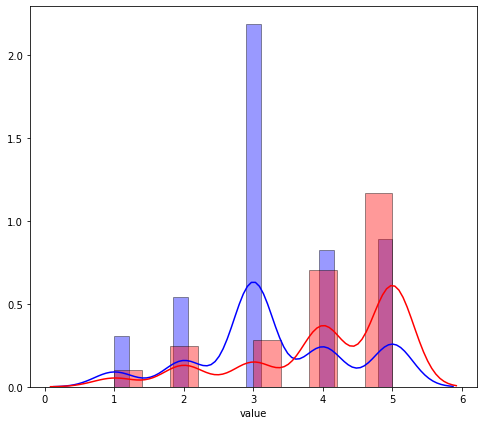

In [191]:
plt.subplots(figsize=(8, 7), sharex=True)
sns.distplot( df_influence_normalize_all["R_system"] , color="blue", label="R_system")
sns.distplot( df_influence_normalize_all["value"] , color="red", label="Value")
plt.show()

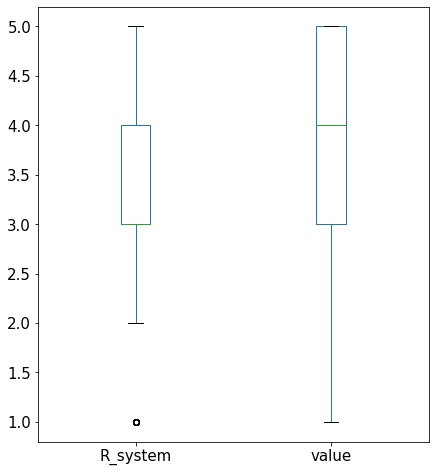

In [205]:
df_influence_normalize_all.boxplot(column=['R_system','value'], grid=False, fontsize=15, figsize=(7,8))

### RMSE

In [177]:
rmse_3 = sqrt(mean_squared_error(df_influence_normalize_all.value, df_influence_normalize_all.R_system))
rmse_3

1.667878347427708

## SEM INFLUENCIA SOCIAL 

### extraindo as musicas por cada usuario da recomendação sem influência social

In [120]:
recommendations_without_influence = recommendations.copy()
recommendations_without_influence.drop(['influence_factors','recommendation_tracks'], axis=1, inplace=True)
recommendations_without_influence.head()

,_id,recommendations_without_influence_tracks,coldstart_id
0,5e4ee62b5ca8220c4dc01354,"[5e4ee9485ca8220c4dc0135f, 5e4ee9485ca8220c4dc...",b'5e3b33d7ed270009cf00da85'
1,5e4eedb35ca8220c4dc01369,"[5e4ef0475ca8220c4dc01374, 5e4ef0485ca8220c4dc...",b'5e3c828776310e1fde421f2c'
2,5e4eda635ca8220c4dc0133f,"[5e4edd9a5ca8220c4dc0134a, 5e4edd9a5ca8220c4dc...",b'5e3726ba1fbed90c602336a4'
3,5e4ef2325ca8220c4dc0137e,"[5e4ef4c85ca8220c4dc0138d, 5e4ef4c85ca8220c4dc...",b'5e39ede810214506a1c42a62'
4,5e4ef7ca5ca8220c4dc013a0,"[5e4efaa75ca8220c4dc013af, 5e4efaa75ca8220c4dc...",b'5e3888bf76eb8c0a84f6030c'


In [121]:
recommendations_without_influence = recommendations_without_influence.explode('recommendations_without_influence_tracks')

In [122]:
recommendations_without_influence =  recommendations_without_influence.rename(columns = {'recommendations_without_influence_tracks':'recommendation_tracks_ids', 'coldstart_user':'coldstart_user_id'})

In [123]:
recommendations_without_influence

,_id,recommendation_tracks_ids,coldstart_id
0,5e4ee62b5ca8220c4dc01354,5e4ee9485ca8220c4dc0135f,b'5e3b33d7ed270009cf00da85'
0,5e4ee62b5ca8220c4dc01354,5e4ee9485ca8220c4dc01360,b'5e3b33d7ed270009cf00da85'
0,5e4ee62b5ca8220c4dc01354,5e4ee9485ca8220c4dc01361,b'5e3b33d7ed270009cf00da85'
0,5e4ee62b5ca8220c4dc01354,5e4ee9485ca8220c4dc01362,b'5e3b33d7ed270009cf00da85'
0,5e4ee62b5ca8220c4dc01354,5e4ee9495ca8220c4dc01363,b'5e3b33d7ed270009cf00da85'
...,...,...,...
19,5e5e7b5c765acb19719b58ba,5e5e7dc1765acb19719b58ca,b'5e5e75bc765acb19719b58b7'
19,5e5e7b5c765acb19719b58ba,5e5e7dc1765acb19719b58cb,b'5e5e75bc765acb19719b58b7'
19,5e5e7b5c765acb19719b58ba,5e5e7dc1765acb19719b58cc,b'5e5e75bc765acb19719b58b7'
19,5e5e7b5c765acb19719b58ba,5e5e7dc1765acb19719b58cd,b'5e5e75bc765acb19719b58b7'


### merge recomendações com fatores de influencia de  todos os users 

In [183]:
recommendations_without_influence_all = pd.merge(recommendations_without_influence, df_factors_all_users, on='coldstart_id')


/home/aleja/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [184]:
recommendations_without_influence_all= recommendations_without_influence_all.drop(columns=[('value_factor', 'expert'),('value_factor', 'friendly'), ('value_factor', 'leadership'),
        ('value_factor', 'similarities')])

recommendations_without_influence_all = recommendations_without_influence_all.rename(columns={('user_id', '') :'user_id', ('value_factor', 'final'): 'final_factor'})

recommendations_without_influence_all.head()

,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor
0,5e4ee62b5ca8220c4dc01354,5e4ee9485ca8220c4dc0135f,b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547
1,5e4ee62b5ca8220c4dc01354,5e4ee9485ca8220c4dc0135f,b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693
2,5e4ee62b5ca8220c4dc01354,5e4ee9485ca8220c4dc0135f,b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125
3,5e4ee62b5ca8220c4dc01354,5e4ee9485ca8220c4dc0135f,b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173
4,5e4ee62b5ca8220c4dc01354,5e4ee9485ca8220c4dc0135f,b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429


### fazendo Merge das recommendações de influencia social com as infos das musicas que tem o valor da predição do sistema

In [185]:
df_not_influence_predictions_all = pd.merge(recommendations_without_influence_all, recommendation_tracks, on="recommendation_tracks_ids")
df_not_influence_predictions_all['recommendation_tracks_ids'] = df_not_influence_predictions_all['recommendation_tracks_ids'].astype('|S')
df_not_influence_predictions_all.head()

,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor,spotify_track_id,name,prediction
0,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527
1,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527
2,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527
3,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527
4,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527


### fazendo merge com os ratings dos usuarios 

In [186]:
df_not_influence_ratings_all =  pd.merge(df_not_influence_predictions_all, ratings, on=["spotify_track_id", "coldstart_id"])
df_not_influence_ratings_all.head()

,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor,spotify_track_id,name,prediction,value
0,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527,5
1,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527,5
2,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527,5
3,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527,5
4,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527,5


### normalizando influence ratings

In [187]:
df_not_influence_normalize_all =  normalize_predictions(df_not_influence_ratings_all)
df_not_influence_normalize_all.head()

,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor,spotify_track_id,name,prediction,value,R_system
0,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527,5,3.0
1,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527,5,3.0
2,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527,5,3.0
3,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527,5,3.0
4,5e4ee62b5ca8220c4dc01354,b'5e4ee9485ca8220c4dc0135f',b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429,5FVd6KXrgO9B3JPmC8OPst,Do I Wanna Know?,1.025527,5,3.0


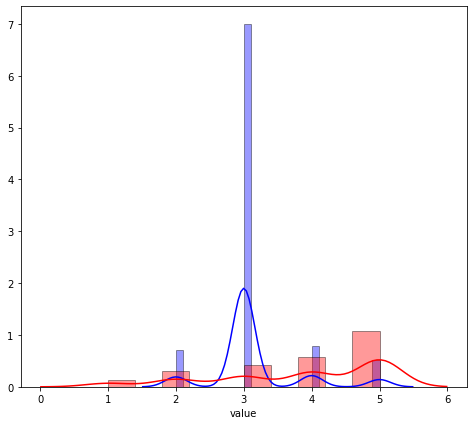

In [188]:
plt.subplots(figsize=(8, 7), sharex=True)
sns.distplot( df_not_influence_normalize_all["R_system"] , color="blue", label="R_system")
sns.distplot( df_not_influence_normalize_all["value"] , color="red", label="Value")
plt.show()

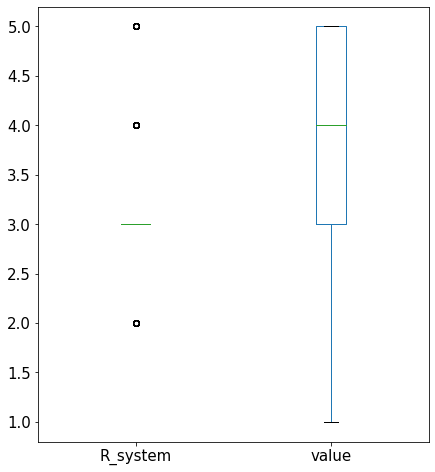

In [189]:
df_not_influence_normalize_all.boxplot(column=['R_system','value'], grid=False, fontsize=15, figsize=(7,8))

In [190]:
rmse_4 = sqrt(mean_squared_error(df_not_influence_normalize_all.value, df_not_influence_normalize_all.R_system))
rmse_4

1.6585081702088027

## COM INFLUENCIA SOCIAL DOS MAIN USERS

## merge  recomendações com  fatores de influenciac dos main users 


In [196]:
recommendations_with_influence_main = pd.merge(recommendations_with_influence, df_factors_main_users, on='coldstart_id')


/home/aleja/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [197]:
recommendations_with_influence_main= recommendations_with_influence_main.drop(columns=[('value_factor', 'expert'),('value_factor', 'friendly'),   ('value_factor', 'leadership'),
        ('value_factor', 'similarities') ])

recommendations_with_influence_main = recommendations_with_influence_main.rename(columns={('user_id', '') :'user_id', ('value_factor', 'final'): 'final_factor'})

recommendations_with_influence_main.head()

,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor
0,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547
1,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693
2,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125
3,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173
4,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429


In [198]:
df_influence_predictions_main = pd.merge(recommendations_with_influence_main, recommendation_tracks, on="recommendation_tracks_ids")
df_influence_predictions_main.head()

,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor,spotify_track_id,name,prediction
0,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
1,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
2,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
3,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
4,5e4ee62b5ca8220c4dc01354,5e4ee9475ca8220c4dc01355,b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738


In [199]:
df_influence_predictions_main['recommendation_tracks_ids'] = df_influence_predictions_main['recommendation_tracks_ids'].astype('|S')
df_influence_predictions_main.head()


,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor,spotify_track_id,name,prediction
0,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
1,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
2,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
3,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738
4,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738


In [200]:
df_influence_ratings_main =  pd.merge(df_influence_predictions_main, ratings, on=["spotify_track_id", "coldstart_id"])
df_influence_ratings_main.style

,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor,spotify_track_id,name,prediction,value
0,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
1,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
2,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
3,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
4,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
5,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e4ea09d53da9b09dcfa3e40,1.230619,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5
6,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01356',b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248,5
7,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01356',b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248,5
8,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01356',b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248,5
9,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01356',b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173,59XNy4523UcEvQfYM8fdQB,Somebody Told Me,2.274248,5


In [201]:
df_influence_normalize_main =  normalize_predictions(df_influence_ratings_main)
df_influence_normalize_main.head()

,_id,recommendation_tracks_ids,coldstart_id,user_id,final_factor,spotify_track_id,name,prediction,value,R_system
0,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3726ba1fbed90c602336a4,1.184547,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.0
1,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e37790d1fbed90c602336ac,1.181693,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.0
2,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3888bf76eb8c0a84f6030c,1.308125,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.0
3,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e39e05f10214506a1c42a61,1.310173,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.0
4,5e4ee62b5ca8220c4dc01354,b'5e4ee9475ca8220c4dc01355',b'5e3b33d7ed270009cf00da85',5e3b33d7ed270009cf00da85,1.090429,1qDrWA6lyx8cLECdZE7TV7,Somebody That I Used To Know,2.307738,5,5.0


In [ ]:
 kernel density estimate

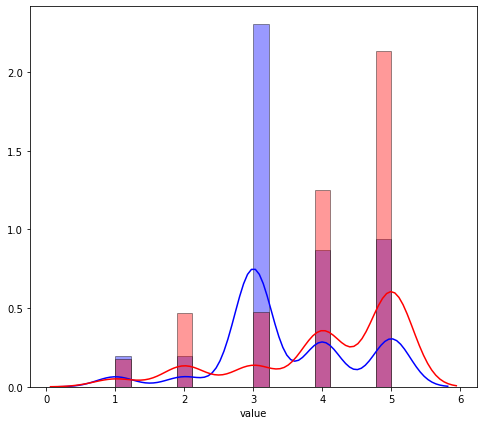

In [221]:
plt.subplots(figsize=(8, 7), sharex=True)
sns.distplot( df_influence_normalize_main["R_system"] , color="blue", label="R_system")
sns.distplot( df_influence_normalize_main["value"] , color="red", label="Value")
plt.show()

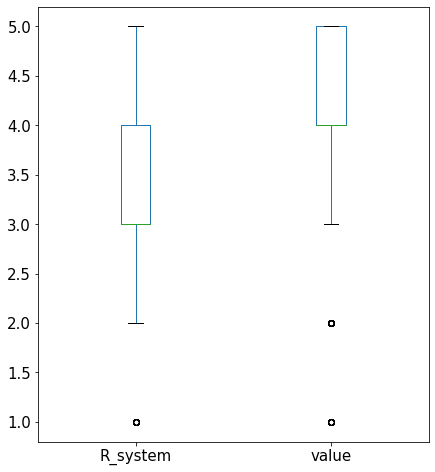

In [203]:
df_influence_normalize_main.boxplot(column=['R_system','value'], grid=False, fontsize=15, figsize=(7,8))


In [204]:
rmse_5 = sqrt(mean_squared_error(df_influence_normalize_main.value, df_influence_normalize_main.R_system))
rmse_5

1.520571842539411

## Average ratings of tracks

In [209]:
ratings_mean_count = pd.DataFrame(df_influence_normalize_main.groupby('name')['value'].mean())


In [210]:
ratings_mean_count['R_system_mean'] = pd.DataFrame(df_influence_normalize_main.groupby('name')['R_system'].mean())

In [211]:
ratings_mean_count


,value,R_system_mean
name,,
Alejandro,1.000000,1.000000
Bad Romance,2.000000,1.000000
Californication,4.111111,3.000000
Chandelier,4.333333,4.000000
Chop Suey!,3.684211,2.684211
Come As You Are,5.000000,3.000000
Counting Stars,5.000000,4.000000
Crawling,4.000000,1.000000
Demons - Live London Sessions / 2013,3.941176,3.647059


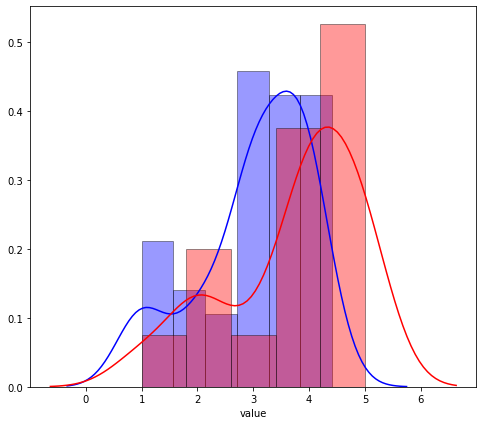

In [212]:
plt.subplots(figsize=(8, 7), sharex=True)
sns.distplot( ratings_mean_count["R_system_mean"] , color="blue", label="R_system")
sns.distplot( ratings_mean_count["value"] , color="red", label="Value")
plt.show()


In [213]:
total_average_ratings.describe()


NameError: name 'total_average_ratings' is not defined

## Let's now add the total number of ratings for track'

In [215]:
ratings_mean_count['ratings_counts'] = pd.DataFrame(df_influence_normalize_main.groupby('name')['value'].count())

In [216]:
ratings_mean_count.head()

,value,R_system_mean,ratings_counts
name,,,
Alejandro,1.000000,1.000000,3
Bad Romance,2.000000,1.000000,3
Californication,4.111111,3.000000,9
Chandelier,4.333333,4.000000,9
Chop Suey!,3.684211,2.684211,19


### Let's plot a histogram for the number of ratings represented by the "rating_counts" column in the above dataframe.

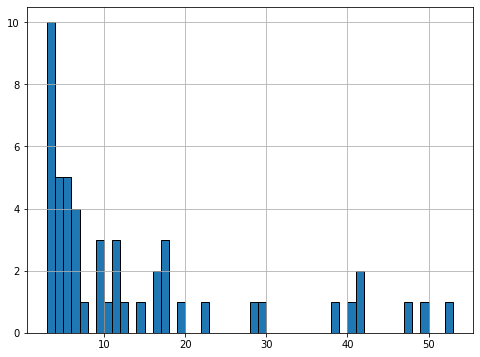

In [217]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['ratings_counts'].hist(bins=50)

In [ ]:
### Now we'll plot a histogram for average ratings. 

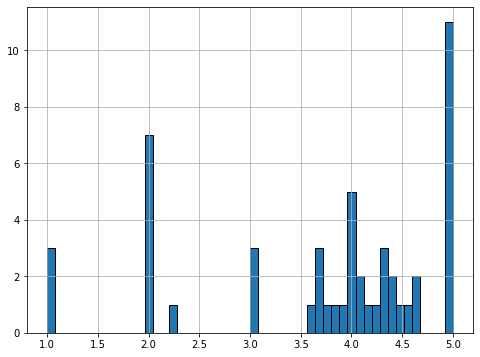

In [218]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['value'].hist(bins=50)